In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")

In [37]:
tf.keras.backend.set_floatx("float64")
h = 6


class DNModel(tf.keras.Model):
    def __init__(self, N, n):
        super().__init__()
        
        self.N = N
        self.n = n
        
        self.dense1 = tf.keras.layers.Dense(32)
        self.dense2 = tf.keras.layers.Dense(32)
        self.out = tf.keras.layers.Dense(1)
        
        self.w = tf.keras.layers.Dense(h)
        self.hidden_initial = tf.Variable(tf.random.normal((1,h), mean=0.0, stddev=1.0, dtype=tf.dtypes.float64))
        self.hidden = tf.repeat(self.hidden_initial, N, axis=0)
        
    def call(self, x):
        x = tf.concat((self.hidden, x), axis=1)  
        x = tf.nn.tanh(self.dense1(x))
        x = tf.nn.tanh(self.dense2(x))

        return tf.math.exp(self.out(x))

    def rnn_forward(self, x):
        x = tf.concat((self.hidden, x), axis=1)
        self.hidden = tf.tanh(self.w(x))
    
    def hidden_reset(self, N=0):
        if N != 0:
            self.N = N
            
        self.hidden = tf.repeat(self.hidden_initial, self.N, axis=0)
        
        
    
@tf.function
def loss(model, x): 
    _x = tf.unstack(x, axis=1)
    _x_ = [tf.expand_dims(tmp, axis = 1) for tmp in _x]
    _x2 = tf.transpose(tf.stack(_x_))[0]
    
    model.hidden_reset()
    psi = 1
    for i in range(model.n):
        psi *= model.call(tf.reshape(_x2[:,i],(-1,1)))
        model.rnn_forward(tf.reshape(_x2[:,i],(-1,1)))
    
    d_psi = [tf.squeeze(tf.gradients(psi, tmp)) for tmp in _x]
    d2_psi = 0
    for ii in range(model.n):
        d2_psi += tf.stack(tf.gradients(d_psi[ii], _x_[ii]))[0]
    
    lap = 1/psi*(d2_psi)
    
    E_L = -0.5*lap + 0.5*tf.reshape(tf.reduce_sum(x**2, axis=1), (-1,1))
    for i in range(model.n):
        for j in range(i):
            E_L += tf.reshape(1/tf.math.sqrt((x[:,i] - x[:,j])**2 + 0.1**2), (-1,1))
    
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)



@tf.function
def grad(model, x):
    with tf.GradientTape() as tape:
        E, loss_value = loss(model, x)

    return E, tape.gradient(loss_value, model.trainable_variables)



def sample(model, N, n):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    psi_old = model(x_old).numpy()
    
    for i in range(n):
        x_new = x_old + 2*tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        psi_new = model(x_new).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

In [38]:
N = 2000
n = 3

energy = []

tf.random.set_seed(42)
np.random.seed(42)
model = DNModel(N, n)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)

In [41]:
num_epochs = 6000

steps = 20
for epoch in tqdm(range(num_epochs)):  
    x = []
    model.hidden_reset()
    for i in range(model.n):
        x.append(sample(model, model.N, steps)[0])
        model.rnn_forward(x[-1])
    
    x = tf.concat(x, axis=1)

    E, gradients = grad(model, x)
    energy.append(E)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E}")

epoch: 0, Energy: 6.117894749156671
epoch: 100, Energy: 6.094798627068265
epoch: 200, Energy: 6.126058873762346
epoch: 300, Energy: 6.1174570509558475
epoch: 400, Energy: 6.115497617247339
epoch: 500, Energy: 6.0511846910749005
epoch: 600, Energy: 5.996107950400884
epoch: 700, Energy: 6.017376514224652
epoch: 800, Energy: 6.129176451419887
epoch: 900, Energy: 6.1099241494783785
epoch: 1000, Energy: 6.034318505615654
epoch: 1100, Energy: 6.039940880531433
epoch: 1200, Energy: 6.051428319373113
epoch: 1300, Energy: 6.052352204054129
epoch: 1400, Energy: 6.076806982403529
epoch: 1500, Energy: 6.049609192649164
epoch: 1600, Energy: 6.043119257886523
epoch: 1700, Energy: 6.078192727011219
epoch: 1800, Energy: 6.067769770184368
epoch: 1900, Energy: 6.049508895464334
epoch: 2000, Energy: 6.059724441557456



KeyboardInterrupt: 

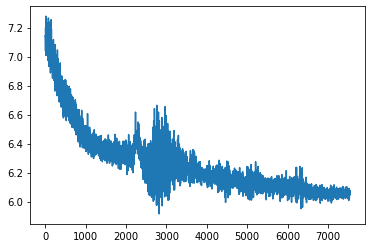

In [42]:
plt.plot(energy[500:])
plt.show()

In [7]:
print(sample(model, N, 20)[1])

22565


In [43]:
def f(x):
    x_lin = np.linspace(-4, 4, N)
    dx = x_lin[1] - x_lin[0]
    tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

    x1 = tf.convert_to_tensor(x*np.ones((N,1)), dtype=tf.dtypes.float64)

    model.hidden_reset(N)
    psi1 = model(tf_x_lin).numpy()[:, 0]
    
    model.rnn_forward(x1)
    psi2 = model(tf_x_lin).numpy()[:, 0]
    
    psi3 = np.exp(-0.5*x_lin**2)

    plt.plot(x_lin, 1/dx*psi1**2/np.sum(psi1**2))
    plt.plot(x_lin, 1/dx*psi2**2/np.sum(psi2**2))
    plt.plot(x_lin, 1/dx*psi3**2/np.sum(psi3**2), "--")
    
    plt.plot(x, 0.01, "bo")
    plt.ylim(0, 0.8)
    plt.show()

interact(f, x=(-4.0, 4., 0.1))

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

<function __main__.f(x)>

#### Estimate energy

In [ ]:
N = 1000000
model.hidden_reset(N)
x1 = sample(model, N, 20)[0]
model.rnn_forward(x1)
x2 = sample(model, N, 20)[0]

x = tf.concat((x1,x2), axis=1)

E, _ = loss(model, x)

print(E)

In [ ]:
N = 1000000
x = []
model.hidden_reset(N)
for i in range(model.n):
    x.append(sample(model, N, steps)[0])
    model.rnn_forward(x[-1])
    
x = tf.reshape(tf.concat(x, axis=1), (-1,1)).numpy()
bins = np.linspace(-3, 3, 200)
plt.hist(x, bins=bins)
plt.show()

In [ ]:
for i in range(5):
    for j in range(i):
        print(i,j)